# Vertical profiles: estimation of MLD

This notebook has a routine that allows to estimate the MLD from a vertical profile on a specific position. The dataset used here is the ARMOR3D and it makes use of the of the gsw python library to manage the conversions and density calculations. The method to estimate the MLD used here is the variable criterion in density equivalent to a $ 0.2^°$C variation in local temperature. The depth considered as the reference is taken at 10m.


For brevity, the notebook only considers one example for one point in the Gulf Stream region and it has the following sections:

   [1. Imported modules](#1.-Imported-modules)
   
   [2. Dictionaries used](#2.-Dictionaries-used)
   
   [3. Functions](#3.-Functions)
   
   [4. Example plot](#4.-Example-plot)

## 1. Imported modelues

In [1]:
import xarray as xr
import numpy as np
import datetime
import pandas as pd
import gsw
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt

## This module disable the print of warnings in the notebook
import warnings; warnings.simplefilter('ignore')

## 2. Dictionaries used

In [2]:
################################################################################
########    DICTIONARIES
################################################################################

## Selected points in the regions
### Gulf S: (60W, 35N)
### Lab -I: (50W, 55N)
### Nor E: (17.5W, 52.5N)
points = {
    'gul': {
        'lon': -55., 
        'lat': 36.
    },
    'lab': {
        'lon': -53., 
        'lat': 58.
    },
    'irm': {
        'lon': -37., 
        'lat': 60.
    },
    'noe': {
        'lon': -17.5, 
        'lat': 52.5}
}



### The following three dictionaries: gulf, labrador
### and north contain the limits for the horizontal
### axis for temperature, density and salinity. This
### values depend on the month we are working on and
### also correspond to the points selected in the 'points'
### dictionary. 
gulf = {
    12 : {
        't': (17.5, 19.), 
        's': (36.45, 36.65),
        'd': (26.3, 26.65)
    },
    25 : {
        't': (17.5, 25.), 
        's': (36.25, 36.75),
        'd': (24., 27.)
    },
    38 : {
        't': (17.5, 26.), 
        's': (36.4, 36.8),
        'd': (24., 26.5)
    },
    51 : {
        't': (18., 22.2), 
        's': (36.4, 36.7),
        'd': (25., 26.5)
    }
}


labrador = {
    12 : {
        't': (2.75, 3.5), 
        's': (34.65, 34.85),
        'd': (27.6, 27.75)
    },
    25 : {
        't': (3., 8.), 
        's': (34.5, 35.),
        'd': (26., 29.)
    },
    38 : {
        't': (3., 11.), 
        's': (34.5, 35.),
        'd': (26., 28.)
    },
    51 : {
        't': (4., 5.5), 
        's': (34.25, 35.),
        'd': (27.2, 27.7)
    }
}


north = {
    12 : {
        't': (10.7, 11.7), 
        's': (35.35, 35.5),
        'd': (26.9, 27.3)
    },
    25 : {
        't': (10., 15.), 
        's': (35.3, 35.7),
        'd': (26.2, 27.2)
    },
    38 : {
        't': (11., 16.), 
        's': (35.3, 35.7),
        'd': (26., 28.)
    },
    51 : {
        't': (11., 13.), 
        's': (35.45, 35.65),
        'd': (26.8, 27.2)
    }
}



"""
reg_ext is a dictionary that has the coordinate
boundaries of the main regions. The format is:
<region> :
  <lon> : (lon1, lon2)
  <lat> : (lat1,  lat2)
  <name> : title for an eventual ploting title
"""

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-25, 20),
        'lat' : (65, 80),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 50.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}




"""
mld_lines is a dictionary that has the parameters
of color, linestyle and line width for the plots
of MLD in function to its stimation. The format is:
<MLD method> :
  <color> : color
  <linestyle> : kind of line
  <linewidth> : thickness of line
"""

mld_lines = {
    'MLDa' : {
        'color' : 'k',
        'linestyle' :'solid', 
        'linewidth' : 3
    },
    'MLDf' : {
        'color' : 'm', 
        'linestyle' : 'solid', 
        'linewidth' : 3
    },
    'MLDv' : {
        'color' : 'c', 
        'linestyle' : 'solid', 
        'linewidth' : 1
    },
    'MLDint' : {
        'color' : 'r', 
        'linestyle' : 'dashdot', 
        'linewidth' : 2
    }
}

## 3. Functions

In [3]:
################################################################################
########    FUNCTIONS
################################################################################

## Function to make the (x,y)-> (lon,lat) grid
def Grid(data_set):
    """
        Grid is a function that creates a rectangular grid using as x a longitude
        array and for y a latitude array.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        Output:
        -------
        (x, y) : n-arrays
            Arrays that correspond for each (lon,lat) point
    """
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)



## Function to crop the dataset
def Crops(coord, d_set, dictionary):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = dictionary[coord]['lon']
    lat1, lat2 = dictionary[coord]['lat']
    name_fig = dictionary[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Limits(dictionary, t):
    """
       Limits is a function that helps to get the limits for the plots
       for the density, temperature and salinity vertical profiles. It
       makes use if dictionaries that contain the limits, pre-defined 
       by hand. The dictionaries are 'gulf', 'labrador' and 'north'.
        
        Parameters:
        ------------
            
        dictionary : 
            Name of the dictionary

        t : int
            Number of week. Each week has different limit. It can be 12, 
            25, 38 or 51.
        
        Output:
        -------
        a, b, c : float [tuples]
            Limits for the plots of each variable. Temperature, salinity 
            and density.
    """
    
    a = dictionary[t]['t']
    b = dictionary[t]['s']
    c = dictionary[t]['d']
    
    return(a, b, c)



def Convert(data_set, t):
    """
        Convert is a function that computes the vertical profile of 
        the potential density from the local temperature and salinity 
        profiles. It makes use of the library gsw. 
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we get temperature and salinity 
            values. The data is given over one particular grid point.
        
        t : integer
            Number of week over which we want to work on.
        
        Output:
        -------
        dep, sa, ct, ds, pr : NumpyArray [floats]
            Vertical profiles of depth, salinity, temperature, potential 
            density and pressure, respectively.
    """
    
    dep = - data_set.depth
    sal = data_set.so[t].values
    tem = data_set.to[t].values
    lon = float(data_set.longitude.values)
    lat = float(data_set.latitude.values)
    
    # Pressure -> depth latitudde
    pr = gsw.p_from_z(dep, lat)
    sa = gsw.conversions.SA_from_SP(sal, pr, lon, lat)
    ct = gsw.conversions.CT_from_t(sa, tem, pr)
    ds = gsw.density.sigma0(sa, ct)

    return(dep, sa, ct, ds, pr)




def New_density(tem_10, sal_10, pss_10, dT=0.2):
    """
        New_density is a function that computes the resulting density
        obtained from a change of dT degrees (Celsius), with respect
        to the reference temperature tem_10 (at 10 m depth).
        
        Parameters:
        ------------
            
        tem_10 : float
            Reference temperature
        
        sal_10 : float
            Salinity at reference depth
        
        pss_10 : float
            Pressure at reference
        
        dT : float
            Change on the reference temperature. By default it has 
            the value of dT=0.2
        
        Output:
        -------
        ds_02, tem_02 : float
            New potential density and temperature, with the dT
    """
    
    pot_10 = gsw.pt0_from_t(sal_10, tem_10, pss_10)
    dpt = pot_10 - dT

    tem_02 = gsw.conversions.CT_from_pt(sal_10, dpt)
    ds_02 = gsw.density.sigma0(sal_10, tem_02)

    return (ds_02, tem_02)



def Point(data_set, coord):
    """
        Point is a function that selects an unique grid point from a
        dataset. It uses specific coordinates defined in a dictionary.
        
        Parameters:
        ------------
        
        data_set : DataArray
            Dataset to use.
        
        coord : string
            Name code for the region from which the point will be selected.
            
        Output:
        -------
        point : DataArray
            New data array corresponding to the point in the region stated 
            by 'coord'.
    """
    
    point = data_set.sel(longitude=points[coord]['lon'], 
           latitude=points[coord]['lat'], method='nearest')
    return(point)



#Function to calculate MLD, according to a threshold value
def ML_depth(depth, density, delta):
    """
        MLD_depth gets the depth and index in which is estimated to 
        be the MLD.The depth value and index are taken from the vertical
        variable of the dataset. To get the depth, density difference
        between one level to the other is computed untill it is larger or
        equal to a delta value.        
        
        Parameters:
        ------------
            
        depth: NumpyArray [float]
            Vertical profile with depth values. 
            
        
        density : NumpyArray [float]
            Density vertical profile.
            
        delta : float
            Threshold value to compare the density differences.
        
        Output:
        -------
        depth[i] : float
            Depth value at which the difference between levels is larger 
            than delta.
        
        i : integer
            Inedx number that identifies the depth.
    """

    for i in range(2, len(density)):
        diff = density[i] - density[1]

        if (diff >= delta):
            return(float(depth[i]), i)
            break

            

def Densities_delta(den, tem, sal, pre, t):
    """
        Densities_delta computes the change in density that is 
        equivalent to a change of 0.2 degree Celsius. 
        
        Parameters:
        ------------
            
        den : NumpyArray [float
            Potential density vertical profile.
            
        tem : NumpyArray [float]
            Temperature vertical profile.
        
        sal : NumpyArray [floats]
            Salinity vertical profile.
            
        pre : NumpyArray [floats]
            Pressure vertical profile.
            
        
        Output:
        -------
        den02, dDv : float
            Values of the new density after a change of 0.2 degree 
            Celsius, and the equivalent change.
    """
    
    # Calculating the density at dT = 0.2 degrees
    # pot temp_10, sal_10m -> New density at dT = 0.2
    den10 = den[1]
    tem10 = tem[1]
    sal10 = sal[1]
    pre10 = pre[1]

    den02, tem02 = New_density(tem10, sal10, pre10)
    dDv = den02 - den10
    
    return(den02, dDv)

In [4]:
################ PLOTS
## dep, tem, sal, ds_g

def Plot_density(ax, dep, tem, sal, den, depth, t=None, name=None, **mld_values):
    """
        Plot_density is a function that plots the vertical profiles of
        density, temperature and salinity. It also draws horizontal lines
        indicating the position of the MLD, given the values.    
        
        Parameters:
        ------------
            
        ax : axes.Axes object
            Current axes in which we make the draw.
            
        dep : Array
            Array with the depth coordinates. Positive going upwards.
        
        tem : Array
            Temperature [oC] profile values.
        
        sal : Array
            Salinity [PSU] profile values.
        
        depth : int
            Limit on y-axis. Given as the index of the depth array.
        
        t : int
            Number of week that corresponds to the plot. This value works together
            with the function 'Limits(reg_name, t)', retrieving the correct axis
            limits. If None, the axis imits are automatically set.
        
        name : string
            Saving name for the output plot. It is recomended to include the path of 
            objective directory. If None, the plot is not saved, and just shown. 
        
        mld_values : float [kwarg]
            Is the list of the MLD estimations. To draw horizontal lines.
            
    """
    lims_t = (np.nanmin(tem[0:depth])-0.5, np.nanmax(tem[0:depth])+0.5)
    lims_s = (np.nanmin(sal[0:depth])-0.05, np.nanmax(sal[0:depth])+0.05)
    lims_d = (np.nanmin(den[0:depth])-0.2, np.nanmax(den[0:depth])+0.2)
    
    # Temperature
    color = 'orange'
    ax.set_xlabel('Temperature [$^o$C]', color=color)
    ax.set_ylabel('Depth [m]')
    ax.plot(tem, dep, color=color)
    ax.tick_params(axis='x', labelcolor=color)
    ax.set_xlim(lims_t)
    
    #xmin = tem.min(skipna=True).values
    #xmax = tem.max(skipna=True).values
    
    for mld, v in mld_values.items(): 
        cl = mld_lines[mld]['color']
        ls = mld_lines[mld]['linestyle']
        lw = mld_lines[mld]['linewidth']
        ax.hlines(v, lims_t[0], lims_t[1], colors=cl, linestyles=ls, linewidths=lw )

    # Salinity
    color = 'blue'
    ax2 = ax.twiny()
    ax2.set_xlabel('Salinity [PSU]', color=color)  
    ax2.plot(sal, dep, color=color)
    ax2.tick_params(axis='x', labelcolor=color)
    ax2.set_xlim(lims_s)
    
    # Density
    color = 'green'
    ax3 = ax.twiny()
    ax3.set_xlabel('Density [kg m$^{-3}$]', color=color)
    ax3.plot(den, dep, color=color)
    ax3.spines["top"].set_position(("axes", 1.10))
    ax3.tick_params(axis='x', labelcolor=color)
    ax3.set_xlim(lims_d)
    
    plt.ylim(dep[depth], 0)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    if name:
        plt.savefig(name)
        

In [5]:
def Year_sel(data_set, yr):
    """
        Year_sel slects an specific year from a dataset.  
        
        Parameters:
        ------------
            
        data_set : DataArray
            Array from we extract the year.
        
        yr : int
            Number of the year we want 
        
        Output:
        ------------
        y : dataArray
            DataArray containing only the data corresponding to yr
            
    """
    cond = data_set.time.dt.year.isin([yr])
    y = data_set.sel(time=cond)
    
    return(y)

def Point_sel(data_set, lon, lat, isel=True):
    """
        Point_sel selects a point given the latitude and longitude, or the 
        index of the array. The default function is using isel. If sel() wants
        to be used, the nearest method is used to select the point.
        
        
        Parameters:
        ------------
            
        data_set : DataArray
            Array from we extract the year.
        
        lon : float
            Coordinate for longitude.
        
        lat : float
            Coordinate for latitude.
        
        Output:
        ------------
        p : dataArray
            DataArray containing only the data corresponding to (lon, lat)
            
    """
    if isel:
        p = data_set.isel(longitude=lon, latitude=lat)
    else:
        p = data_set.sel(longitude=lon, latitude=lat, method='nearest')
    
    return(p)

## 4. Example plot

In [6]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

## Opening files and directories in & out

dir_1 = '/net/krypton/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'
dir_2 = '../../../New_ARMOR/'
dir_3 = '../../Vertical-prof/'

fl_n1 = 'ARMOR_*'
fl_n2 = 'NARMOR_*'


c_armor1 = xr.open_mfdataset(dir_1 + fl_n1)
c_armor2 = xr.open_mfdataset(dir_2 + fl_n2, concat_dim='time')

In [7]:
## Adding time stamps to the dataset

d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor2.coords['time'] = (('time'), weeks)

In [8]:
## Calculating monthly mean
mean1 = c_armor1.groupby('time.month').mean(dim='time')
mean2 = c_armor2.groupby('time.month').mean(dim='time')

In [9]:
## Deliting large datasets, free some memory

del c_armor1, c_armor2

In [10]:
## Croping the dataset in a smaller region,
## this is not necessary.

gul1 = Crops('gul', mean1, reg_ext)
gul2 = Crops('gul', mean2, reg_ext)

### 4.1 Gulf Stream

What we do here is to selecta point in space in a specific month, denoted by $t$. 

In [11]:
## Selected points in the regions:: this are the points
## in the dictionaries in the previous sections.
## Gulf S: (60W, 35N)
## Lab -I: (50W, 55N)
## Nor E: (17.5W, 52.5N)

In [22]:
## Getting the information from a grid point

gul1_p = Point(gul1, 'gul')
gul2_p = Point(gul2, 'gul')

## Coord to use: gulf, labrador or north, 
## and number of the month t
place = gulf
t = 3

In [23]:
## Calculating the depth, salinity, temperature,
## density and pressure profiles for the point at time t.

dep, sal, tem, den, pre = Convert(gul1_p, t)

In [24]:
## Calculating the deltas

dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

In [25]:
print (Ddv_gl)

0.06531500481332841


In [26]:
## Calculating the depth, using fixed (MLD_f) and
## variable (MLD_v) criteria. 

MLD_a = gul2_p.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

In [27]:
## Calculating depth from density :: Interpolation

x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

In [28]:
## Preparing values for the plot.

## Print and getting the MLD values to plot
MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))

## List of MLD values to plot, to compare.
mld_values =  {'MLDa' : - MLD_a, 'MLDf' : MLD_f, 'MLDv' : MLD_v, 'MLDint' : MLD_int}

## reg_name:: gulf, labrador, north

MDL by ARMOR:  68.30
MDL fixed: -75.00
MDL by variable: -100.00
MDL by variable+interpolation: -98.80


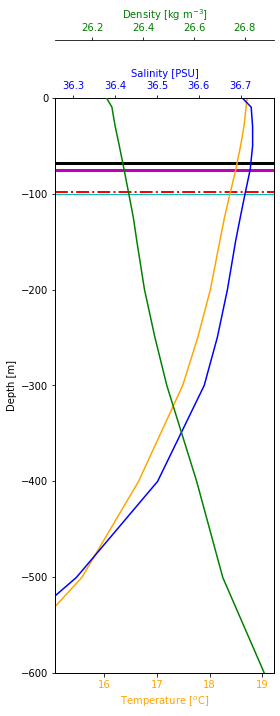

In [29]:
## Plotting

## To save the figure, un-comment next line
#name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 10))
Plot_density(ax, dep, tem, sal, den, 14, t=None, name=None, **mld_values)

plt.show()